In [1]:
import os
import sys
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
class CustomDataset(Dataset):
    def __init__(self, labels_file, file_dir, transform=None):
        self.labels = pd.read_csv(labels_file)
        self.labels_array = np.array(torch.tensor(self.labels.iloc[:, 1]))
        self.file_dir = file_dir
        self.transform = transform


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        file_path = os.path.join(self.file_dir, self.labels.iloc[idx,0])
        file = np.genfromtxt (file_path,dtype=int, delimiter=",")
        file = np.pad(file, (0, 769024 - len(file)))
        file = torch.from_numpy(file).float().reshape( 1, -1)
        label = self.labels.iloc[idx,1]
        sample = {"file" : file, "label": label}
        return sample

In [4]:
file_dir = "/home/marcus/Documents/munzwurf/data"

customData = CustomDataset(os.path.join(file_dir, "labels.csv"), file_dir)

In [5]:
random_indices = np.array(np.floor(np.random.rand(100) * 1000), dtype=int)
print(random_indices)
#tested a bunch of random indices to get a balanced representation of labels
tested_indices = [ 75, 296, 705, 917, 596, 117, 987, 681, 746, 189, 868, 661, 752, 462, 362, 322,  50,  90,
 526,  53, 15, 403, 881, 226, 428, 453,  80, 312, 486, 690, 842, 959, 247, 224, 748, 772,
 620, 617, 108,  96, 212, 649, 866, 707, 956, 772, 234, 339, 166, 954, 602, 935, 707, 717,
  14, 672, 891, 415, 199, 511,   2, 998, 628, 651,  47, 115, 966,  29,   5, 240, 371,  85,
  18, 997,  68, 170, 325, 807, 378, 566, 763, 121,   3, 442, 674, 938, 393, 763, 755, 336,
 419, 408, 104, 923, 580, 530, 859, 371, 957, 535]


[449 708  96 748 164 518  43 658 959 339 430 377 827 218 135 441 584  35
 925 312 474 804 623 121 926 115 847 212 449 116 639 726 410 932  41 317
 517 861 296 279 100 432 565 325 851 544 162 900 499 799 551 863 467 233
 364 739 229 203 899  66 498 898 538 852 537  67 723  81 990 359 305 855
 993 992 898   1 418 100 671 506 666 278 447 775 570 805 568 873 134  24
 385 992 721 156 116 429 984 913 232 139]


In [6]:
test_labels = np.array([], dtype=int)
for i in range(len(random_indices)):
    test_labels = np.append(test_labels, customData.labels_array[tested_indices[i]])
print(test_labels)

[5 6 3 5 5 4 1 3 6 5 1 5 6 0 6 0 3 2 3 4 5 1 3 2 5 3 3 2 6 1 1 2 2 4 6 0 5
 1 5 1 1 3 2 5 4 0 1 5 3 6 4 4 5 5 4 0 1 3 6 6 3 0 0 3 1 2 0 6 6 3 5 1 2 6
 0 2 2 6 4 3 2 4 0 4 6 0 6 2 0 0 1 0 4 5 3 2 6 5 4 0]


<BarContainer object of 7 artists>

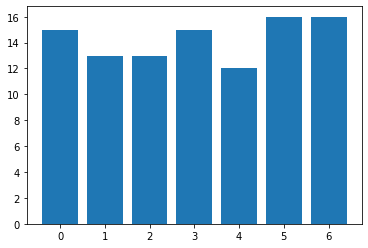

In [7]:
label_count = []
for i in range(7):
    label_count.append(np.count_nonzero(test_labels == i))

plt.bar(range(7), label_count)

In [8]:
train_data = Subset(customData, tested_indices)
test_data = Subset(CustomDataset, np.arange(800, len(customData)))
train_dataloader = DataLoader(train_data, batch_size=4, shuffle=True, pin_memory=False, num_workers=4)
test_dataloader  = DataLoader(test_data, batch_size=4, shuffle=True, pin_memory=False, num_workers=4)

In [9]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv1d(1, 1, kernel_size=3) 
        self.conv2 = nn.Conv1d(1, 1, kernel_size=3) 
        self.conv3 = nn.Conv1d(1, 1, kernel_size=3) 
        self.conv4 = nn.Conv1d(1, 1, kernel_size=3) 
        self.conv5 = nn.Conv1d(1, 1, kernel_size=3) 
      
        self.fc1   = nn.Linear(24030, 7)
     
        
        
    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)),2)
        x = F.max_pool1d(F.relu(self.conv2(x)),2)
        x = F.max_pool1d(F.relu(self.conv3(x)),2)
        x = F.max_pool1d(F.relu(self.conv4(x)),2)
        x = F.max_pool1d(F.relu(self.conv5(x)),2)

        x = torch.flatten(x, 1) 

        x = F.relu(self.fc1(x))
        x = F.softmax(x)

        
        return x

In [10]:
model = Network().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Network(
  (conv1): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (conv5): Conv1d(1, 1, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=24030, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=7, bias=True)
)
168293


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)


In [ ]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data["file"]
        labels = data["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([4, 3, 3, 4], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 4, 5, 3], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109]],
       device='cuda:0', gra

tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([5, 1, 1, 5], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([5, 3, 0, 1], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109]],
       device='cuda:0', gra

tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([4, 6, 1, 4], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1898, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([5, 0, 3, 5], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', gra

tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([5, 6, 0, 0], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([6, 6, 2, 3], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', gra

tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([2, 4, 4, 6], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([0, 5, 4, 5], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', gra

tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([3, 6, 5, 6], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([1, 2, 2, 3], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', gra

tensor([[0.1350, 0.1157, 0.1356, 0.1960, 0.1896, 0.1172, 0.1109],
        [0.1350, 0.1157, 0.1356, 0.1960, 0.1896, 0.1172, 0.1109],
        [0.1350, 0.1157, 0.1356, 0.1960, 0.1896, 0.1172, 0.1109],
        [0.1350, 0.1157, 0.1356, 0.1960, 0.1896, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([6, 2, 4, 3], device='cuda:0')
tensor([[0.1350, 0.1157, 0.1356, 0.1960, 0.1896, 0.1172, 0.1109],
        [0.1350, 0.1157, 0.1356, 0.1960, 0.1896, 0.1172, 0.1109],
        [0.1350, 0.1157, 0.1356, 0.1960, 0.1896, 0.1172, 0.1109],
        [0.1350, 0.1157, 0.1356, 0.1960, 0.1896, 0.1172, 0.1109]],
       device='cuda:0', grad_fn=<SoftmaxBackward>) tensor([3, 4, 5, 5], device='cuda:0')
tensor([[0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109],
        [0.1349, 0.1157, 0.1356, 0.1960, 0.1897, 0.1172, 0.1109]],
       device='cuda:0', gra